# Bootstrapping and Permutation Tests
In class we learned how to perform bootstrapping, and permutation tests. In today's lab we'll use both of these methods to 1) build a random forest almost from scratch, and assess how well singificantly different a machine learning model is from luck or random chance performance. After this lab you should have a deeper understanding of how both of these methods are implemented by libraries in Python.

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
import random
from tqdm import tqdm, tqdm_notebook

In [86]:
breastCancer = datasets.load_breast_cancer()
X_all = breastCancer.data
randomNumGen = np.random.RandomState(seed=23)
E = randomNumGen.normal(size=X_all.shape, loc = 0.0, scale = 1)
# Add noisy data to the informative features for make the task harder
X_all += E
y_all = breastCancer.target
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.25, random_state = 23)

## Part 1: Bootstrapping, Aggregation, and Random Forests
In this section you'll implement a random forest model. Don't worry, you'll have ample access to scikit-learn libraries, but you won't be able to use the [RandomForestClassifer](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) because that would defeat the purpose of learning some of the ins and outs of this model.

### Things to worry about
1. What happens when you call fit on a model multiple times?
2. Are you sampling with replacement during bootstrapping?
3. Inevitable heat death of the universe
4. What's for dinner?

### Deliverables
Fill in the ensemble model code below and using the comparison code below train it for 1,2,3,...,10 learners.

In [59]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import resample
class ensembleClassifier(BaseEstimator, ClassifierMixin):  
    """Random Forest classifer"""

    def __init__(self, nEstimators):
        """
        Called when initializing the classifier
        """
        self.nEstimators = nEstimators



    def generateBootStrapData(self, X, y):
        bootStrapSampleIdxs = np.array(random.choices(np.arange(X.shape[0]), k = X.shape[0]))
#         return(resample(X, y, replace = True, n_samples = X.shape[0]))
        return(X[bootStrapSampleIdxs], y[bootStrapSampleIdxs])

    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.

        Note: assert is not a good choice here and you should rather
        use try/except blog with exceptions. This is just for short syntax.
        """
        self.estimators_ = [LogisticRegression(solver = "liblinear") for i in range(self.nEstimators)]

        if self.nEstimators > 1:
            for estimator in self.estimators_:
                X_bootStrap, y_bootStrap = self.generateBootStrapData(X, y)
                estimator.fit(X_bootStrap, y_bootStrap)
        else:
            self.estimators_[0].fit(X, y)

        return(self)


    def predict(self, X):
        try:
            getattr(self, "estimators_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        predictions = [estimator.predict(X) for estimator in self.estimators_]
        predictions = np.array(predictions)
        predictions = np.mean(predictions, axis = 0)
        predictions[predictions >= 0.5] = 1
        predictions[predictions < 0.5] = 0
        return(predictions)

    def score(self, X, y):
        predictions = self.predict(X)
        accuracy = np.mean(predictions == y)
        return(accuracy) 

In [88]:
clf_ens = ensembleClassifier(nEstimators = 2)#newton-cg', 'sag', 'saga' and 'lbfgs'
clf_ens.fit(X = X_train, y = y_train)
score = clf_ens.score(X_test, y_test)
print(score)

0.9090909090909091


In [89]:
def testClassifier(X_train, y_train, X_test, y_test, nEstimators):
    allScores = []
    nRuns = 100
    for i in range(nRuns):
        clf_ens = ensembleClassifier(nEstimators = nEstimators)#newton-cg', 'sag', 'saga' and 'lbfgs'
        clf_ens.fit(X = X_train, y = y_train)
        score = clf_ens.score(X_test, y_test)
        allScores.append(score)
    mean = np.mean(allScores)
    std = np.std(allScores)
    print("Average score for {} runs and {} estimators: {} (std:{})".format(nRuns, nEstimators, mean, std))

In [90]:
for i in np.arange(1, 11, 1):
    testClassifier(X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, nEstimators = i)

Average score for 100 runs and 1 estimators: 0.9370629370629366 (std:4.440892098500626e-16)
Average score for 100 runs and 2 estimators: 0.9318881118881117 (std:0.011769045866523874)
Average score for 100 runs and 3 estimators: 0.9299300699300699 (std:0.009937946250903796)


KeyboardInterrupt: 

## Part 2: Permutation Tests
No we want to test if a classifier of our choice is better than a simple majority classifier, and assess how sure we are of this claim. We're going to use this by using even more bootstrapping to create new trainig datasets, train our classifier, and assess performance on the same test set. **You can use any classification model you want as long as it's accessible from sklearn, otherwise you're gonna have a bad time. You can even use your ensemble model.**

In order to do this we're going to use our bootstrap model above to assess performance on even more bootstrap data. The general algorthm is as follows.

Given $X_{train}$, $y_{train}$, $X_{test}$ and $y_{test}$ as inputs do.
1. Sample $X^{bs}_{train}$ from $X_{train}$ and $y^{bs}_{train}$, from $y_{train}$ using the bootstrap algorithm.
2. Train our model using $X^{bs}_{train}$
3. Evaluate the ensemble model on $X_{test}$ and $y_{test}$
4. Store our test statistic (accuracy)


Next evaluate whether or not a majority classifier trained on $X_{train}$ and evaluated on $X_{test}$ has performance within the 95% confidence intervals of the ensemble model. Note: A majority classifier simple takes the majority class in the training set and assigns the class to all values it's evaluated on


### Deliverables
Plot a histogram of the ensemble model's bootstrap performance with vertical lines for the lower and upper confidence interval as well as for the majority classifer performance. You can get all but the majority classifier values from the function `calculateConfidenceIntervals`

In [95]:
def calculateConfidenceIntervals(X_train, y_train, X_test, y_test, R, nEstimators, confInterval = 0.95):
    allScores = [0.0]*R
    for r in tqdm_notebook(range(R)):
        clf_ense = ensembleClassifier(nEstimators = nEstimators)
        clf = LogisticRegression(solver = "liblinear")
        clf = clf_ens
        X_bs_train, y_bs_train = clf_ens.generateBootStrapData(X = X_train, y = y_train)
        clf.fit(X = X_bs_train, y = y_bs_train)
        score = clf.score(X_test, y_test)
        allScores[r] = score
    allScores = np.sort(allScores)
    nTrim = int(np.ceil(((1 - confInterval)/2)*R))
    print("Trimming off {} elements from either side of scores".format(nTrim))
    lowerConfBound = allScores[(nTrim - 1)]
    upperConfBound = allScores[-nTrim]
    return(allScores, lowerConfBound, upperConfBound)

In [96]:
allScores, lowerConfBound, upperConfBound = calculateConfidenceIntervals(X_train = X_train, y_train = y_train,
                                                                         X_test = X_test, y_test = y_test, R = 1000,
                                                                         nEstimators = 4, confInterval = 0.95)


Trimming off 26 elements from either side of scores


In [97]:
if np.mean(y_train) >= 0.5:
    majorityClass = 1
else:
    majorityClass = 0
majorityClassiferPerf = np.mean(y_test == majorityClass)
print("majority classifier performance = {}".format(majorityClassiferPerf))

majority classifier performance = 0.6643356643356644


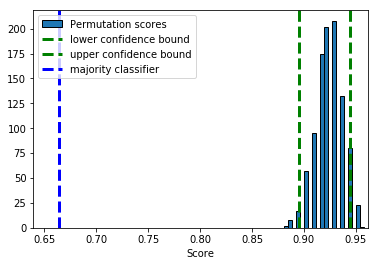

In [98]:
plt.hist(allScores, bins = 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
xlim = plt.xlim()
if xlim[0] > majorityClassiferPerf:
    xlim = (majorityClassiferPerf - 0.025, xlim[1])
plt.vlines(lowerConfBound, ymin = ylim[0], ymax = ylim[1], linestyle='--',
         color='g', linewidth=3,
         label = "lower confidence bound")
plt.vlines(upperConfBound, ymin = ylim[0], ymax = ylim[1], linestyle='--',
         color='g', linewidth=3,
         label = "upper confidence bound")
plt.vlines(majorityClassiferPerf, ymin = ylim[0], ymax = ylim[1], linestyle='--',
         color='b', linewidth=3,
         label = "majority classifier")
plt.ylim(ylim)
plt.xlim(xlim)
plt.legend()
plt.xlabel('Score')
plt.show()